# Import Libraries

In [1]:
!pip install tensorflow gradio

In [2]:
# Data Analysis and Visualization Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gradio as gr
import io
from PIL import Image

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

# Plt initial setup
plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline

# Tf version and GPU availability check
print("Tf version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

Tf version: 2.19.0
GPU available: []


# Download and Load MNIST

In [3]:
# Load MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Dataset Information
print(f"\n - Training data shape and training label shape: {X_train.shape}; {y_train.shape}")
print(f" - Test data shape and test label shape: {X_test.shape}; {y_test.shape}")
dimension = "x".join(map(str, X_train.shape[1:]))
print(f" - Sample dimension: {dimension}")

# Label Information
print("\n - Number of labels: ", len(y_train))
print(" - Show 10 train labels:", np.unique(y_train))

# Pixel Information
print(f" - Pixel range: {X_train.min()} to {X_train.max()}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

 - Training data shape and training label shape: (60000, 28, 28); (60000,)
 - Test data shape and test label shape: (10000, 28, 28); (10000,)
 - Sample dimension: 28x28

 - Number of labels:  60000
 - Show 10 train labels: [0 1 2 3 4 5 6 7 8 9]
 - Pixel range: 0 to 255


# EDA

## Plot Sample

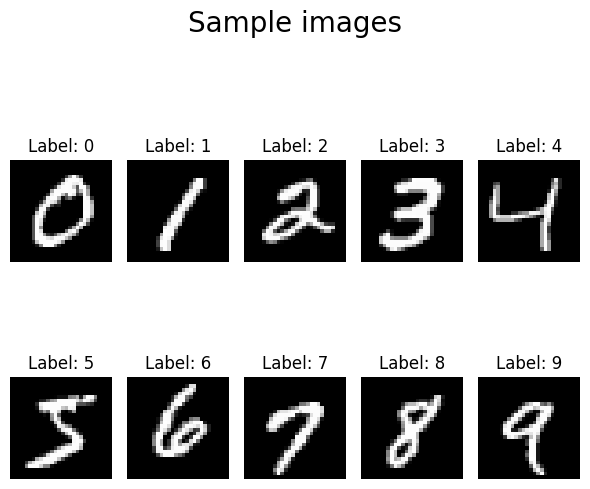

In [4]:
# Sample Plot Llabel 0 - 9
def plot_samples(X, y, num_samples, parameters):
    plt.figure(figsize=(6, 6))

    for samp in range(num_samples):
        plt.subplot(2, 5, samp + 1)

        # Show Distinct Label
        if parameters == 1:
            samp_idx = np.where(y_train == samp)[0][0]
            plt.imshow(X[samp_idx], cmap='gray')
            plt.title(f"Label: {y[samp_idx]}")
            plt.axis('off')

        # Randow Label
        elif parameters == 0:
            plt.imshow(X[samp], cmap='gray')
            plt.title(f"Label: {y[samp]}")
            plt.axis('off')

    plt.suptitle('Sample images', fontsize=20)
    plt.tight_layout()
    plt.show()

plot_samples(X_train, y_train, 10, 1)

## Labels Distribution

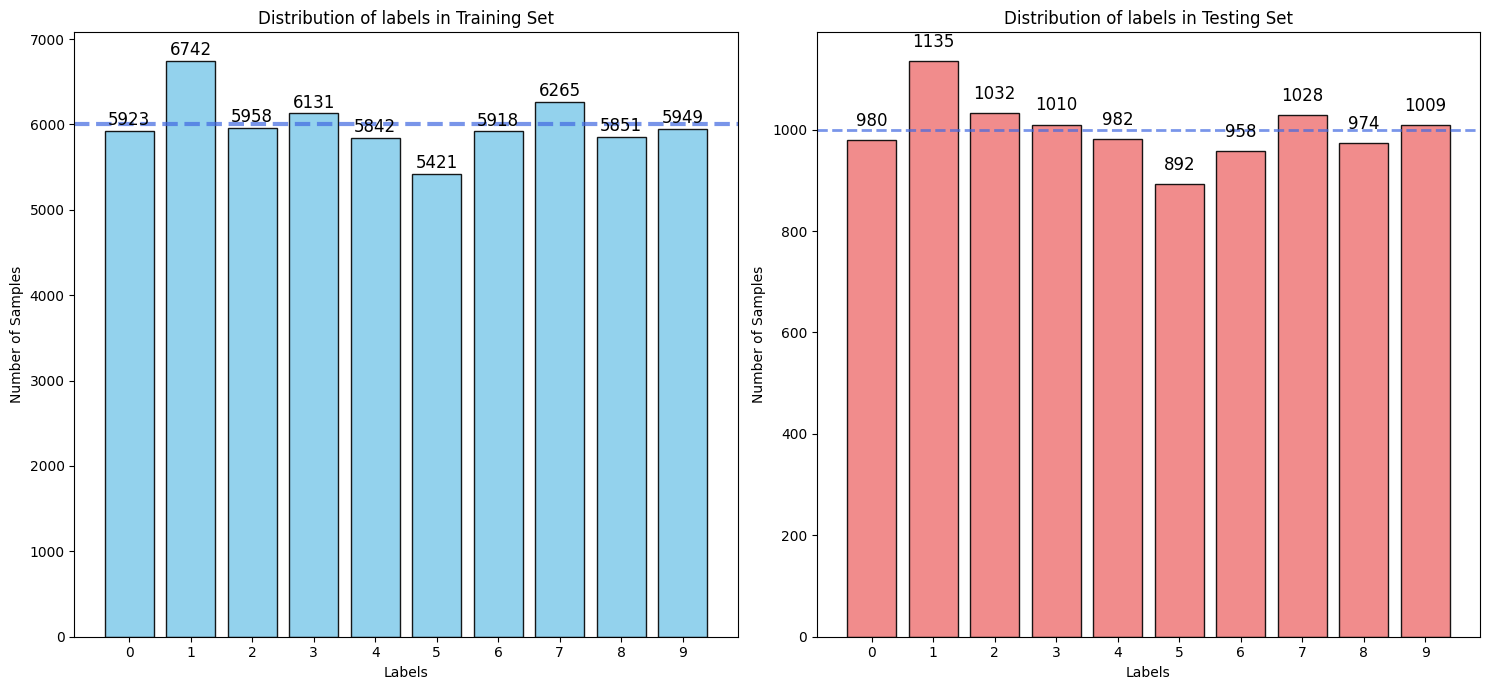

In [5]:
train_labels, train_nums = np.unique(y_train, return_counts=True)
test_labels, test_nums = np.unique(y_test, return_counts=True)

# Label Distribution Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

def plot(ax):

    # Training Set Distribution
    if ax == ax1:
        ax.bar(train_labels, train_nums, color='skyblue', edgecolor='black', alpha=0.9)
        ax.set_title('Distribution of labels in Training Set')

        # Add Number above Bars
        for i, num in enumerate(train_nums):
            ax.text(i, num + 20, str(num), ha='center', va='bottom', fontsize=12)

        # Average Line
        ax.axhline(y=train_nums.mean(), color='royalblue', linestyle='--', linewidth=3, alpha=0.7)

    # Testing Set Distribution
    if ax == ax2:
        ax.bar(test_labels, test_nums, color='lightcoral', edgecolor='black', alpha=0.9)
        ax.set_title('Distribution of labels in Testing Set')

        # Add Number above Bars
        for i, num in enumerate(test_nums):
            ax.text(i, num + 20, str(num), ha='center', va='bottom', fontsize=12)

        # Average Line
        ax.axhline(y=test_nums.mean(), color='royalblue', linestyle='--', linewidth=2, alpha=0.7)

    ax.set_xlabel('Labels')
    ax.set_ylabel('Number of Samples')
    ax.set_xticks(train_labels)

plot(ax1)
plot(ax2)
plt.tight_layout()
plt.show()

## Labels Variations

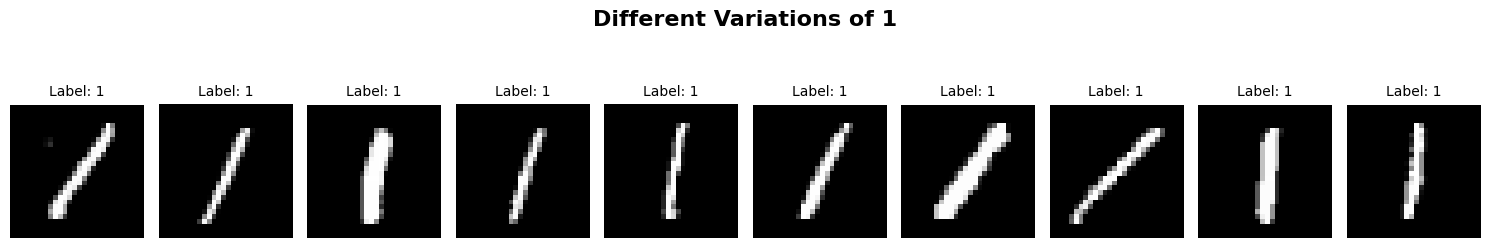

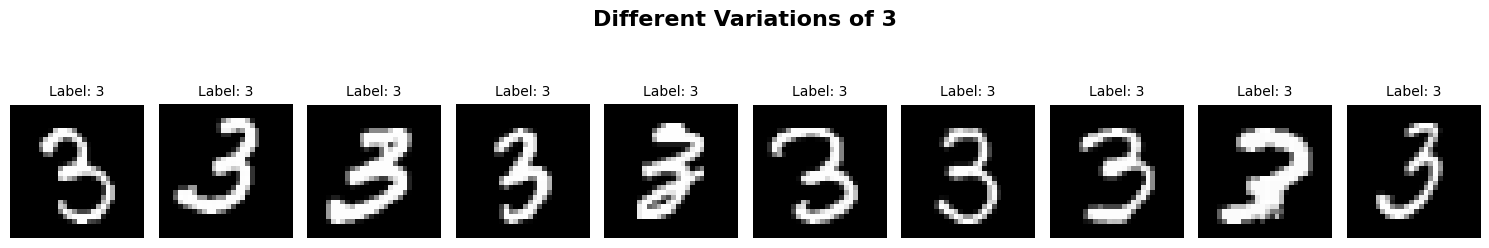

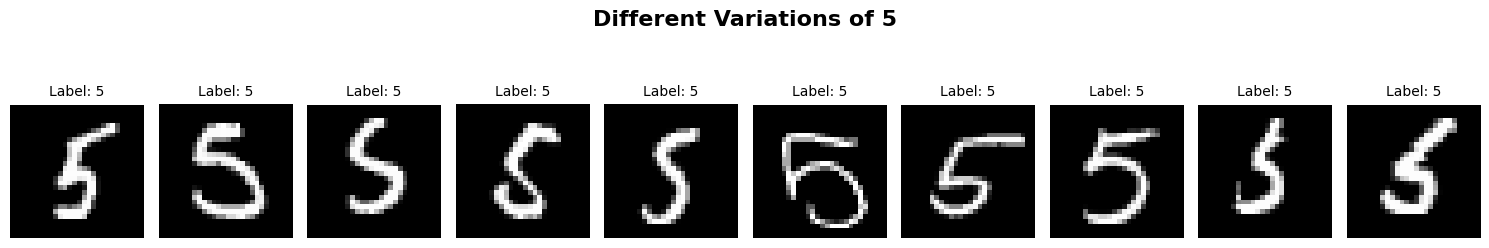

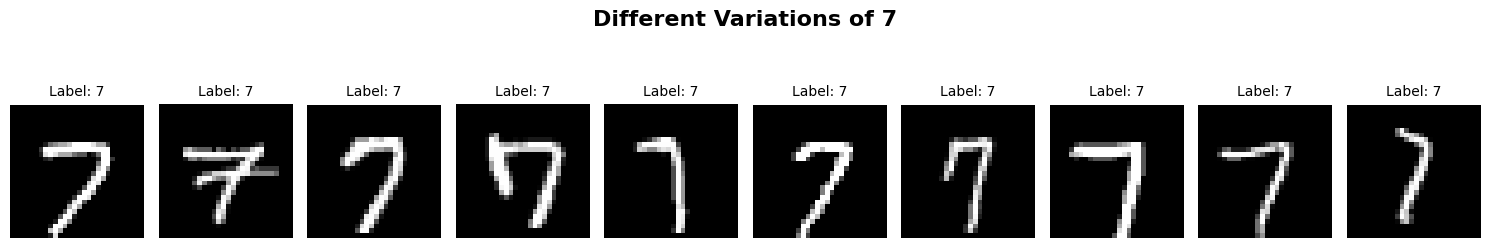

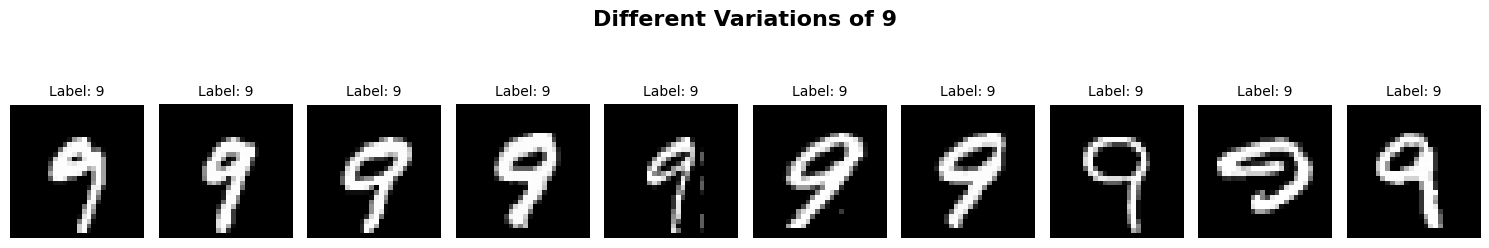

In [6]:
# Show 10 Variations of 5 Odd Digits
def show_digit_vars(X, y, digit, num_samples):

    # Find All Variations of this Digit
    digit_idx = np.where(y == digit)[0]

    # Choose Random Samples
    rand_idx = np.random.choice(digit_idx, num_samples, replace=False)

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(rand_idx):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[idx], cmap='gray')
        plt.title(f'Label: {y[idx]}', fontsize=10)
        plt.axis('off')

    plt.suptitle(f'Different Variations of {digit}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

for digit in [1, 3, 5, 7, 9]:
    show_digit_vars(X_train, y_train, digit, 10)

## Pixel Intensity

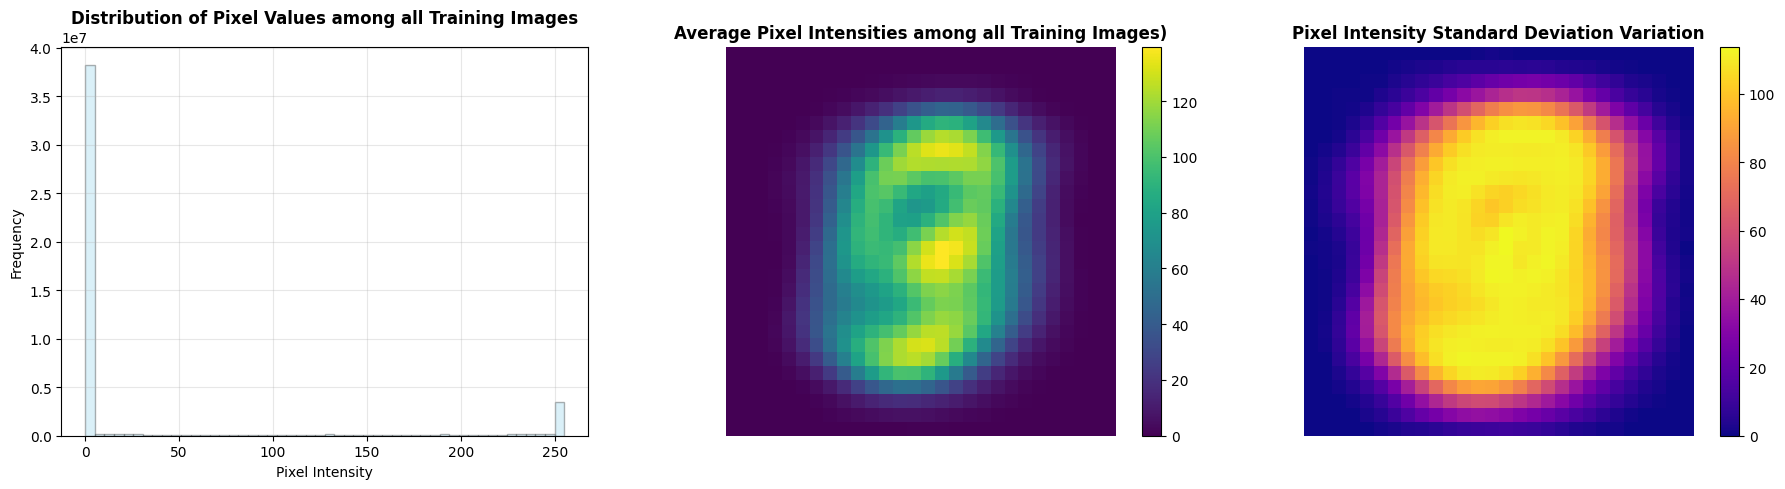


Percentage of black (0) pixels: 80.9%
Percentage of white (255) pixels: 0.7%


In [7]:
# Analyze Pixel Intensity
def analyze_intensity(X):

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Pixel Value Histogram
    axes[0].hist(X.flatten(), bins=50, color='skyblue', alpha=0.3, edgecolor='black')
    axes[0].set_title('Distribution of Pixel Values among all Training Images' , fontweight='bold')
    axes[0].set_xlabel('Pixel Intensity')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, alpha=0.3)

    # Average Pixel Intensity
    mean_image = np.mean(X, axis=0)
    im1 = axes[1].imshow(mean_image, cmap='viridis')
    axes[1].set_title('Average Pixel Intensities among all Training Images)', fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046)

    # Pixels Standard Deviation
    std_image = np.std(X, axis=0)
    im2 = axes[2].imshow(std_image, cmap='plasma')
    axes[2].set_title('Pixel Intensity Standard Deviation Variation', fontweight='bold')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046)

    plt.tight_layout()
    plt.show()

    # Conclusion
    print(f"\nPercentage of black (0) pixels: {(X == 0).mean() * 100:.1f}%")
    print(f"Percentage of white (255) pixels: {(X == 255).mean() * 100:.1f}%")

analyze_intensity(X_train)

# Data Preprocessing Pipeline

In [8]:
# 1. Normalize pixel values
X_train_normalized = X_train.astype('float') / 255.0
X_test_normalized = X_test.astype('float') / 255.0

print(f"Original value range: {X_train.min()} - {X_train.max()} transformed to {X_train_normalized.min()} - {X_train_normalized.max()}")

# 2. Reshape Data

# Flatten Data to 1D for ML
X_train_flat = X_train_normalized.reshape(X_train_normalized.shape[0], -1)
X_test_flat = X_test_normalized.reshape(X_test_normalized.shape[0], -1)

print(f"\nOriginal shape {X_train_normalized.shape} flattened to {X_train_flat.shape}")

# Add channel for Neural Networks
X_train_nn = X_train_normalized.reshape(X_train.shape[0], 28, 28, 1)
X_test_nn = X_test_normalized.reshape(X_test.shape[0], 28, 28, 1)

print(f"\nOriginal shape {X_train_normalized.shape} added channel to {X_train_nn.shape}")

# 3. One-hot encoding labels
y_train_onehot = keras.utils.to_categorical(y_train, 10)
y_test_onehot = keras.utils.to_categorical(y_test, 10)

print(f"\nOriginal shape {y_train.shape} one-hot encoded to {y_train_onehot.shape}")

# 4. Create validation sets

# Split for ML
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_flat, y_train, test_size=0.1, random_state=42, stratify=y_train
)

# Split for NN
X_train_nn_split, X_val_nn, y_train_onehot_split, y_val_onehot = train_test_split(
    X_train_nn, y_train_onehot, test_size=0.1, random_state=42, stratify=y_train
)

print(f"\nML Train/Val/Test: {X_train_split.shape[0]} / {X_val.shape[0]} / {X_test.shape[0]}")
print(f"\nNN Train/Val/Test: {X_train_nn_split.shape[0]} / {X_val_nn.shape[0]} / {X_test_nn.shape[0]}")

Original value range: 0 - 255 transformed to 0.0 - 1.0

Original shape (60000, 28, 28) flattened to (60000, 784)

Original shape (60000, 28, 28) added channel to (60000, 28, 28, 1)

Original shape (60000,) one-hot encoded to (60000, 10)

ML Train/Val/Test: 54000 / 6000 / 10000

NN Train/Val/Test: 54000 / 6000 / 10000


# Machine Learning Models

## Logistic Regresison

### Build and Train

In [9]:
# Build Logistic Regression Model
lr = LogisticRegression(
    penalty='l2',
    random_state=42,
    solver='lbfgs',
    max_iter=1000,
    multi_class='multinomial'
)

# Model Information
print(f"\nLogistic Regression parameters:\n")
print(f" - Type: {type(lr).__name__}")
params = lr.get_params()
for param, value in params.items():
    print(f" - {param}: {value}")


Logistic Regression parameters:

 - Type: LogisticRegression
 - C: 1.0
 - class_weight: None
 - dual: False
 - fit_intercept: True
 - intercept_scaling: 1
 - l1_ratio: None
 - max_iter: 1000
 - multi_class: multinomial
 - n_jobs: None
 - penalty: l2
 - random_state: 42
 - solver: lbfgs
 - tol: 0.0001
 - verbose: 0
 - warm_start: False


In [10]:
# Mark starting time
start_time = time.time()

# Train Model
lr.fit(X_train_split, y_train_split)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training time: 106.28 seconds


### Evaluate

In [17]:
# Evaluate Model on Validation Set
logistic_val_pred = lr.predict(X_val)
logistic_val_accuracy = accuracy_score(y_val, logistic_val_pred)
print(f"Validation Accuracy: {logistic_val_accuracy*100:.2f}%")

# Evaluate Model on Test Set
logistic_test_pred = lr.predict(X_test_flat)
logistic_test_accuracy = accuracy_score(y_test, logistic_test_pred)
print(f"\nTest Accuracy: {logistic_test_accuracy*100:.2f}%")

# Compare Performance on Validation Set and Test Set
print(f"\nValidation Accuracy: {logistic_val_accuracy*100:.2f}%")
print(f"Test Accuracy: {logistic_test_accuracy*100:.2f}%")

logistic_overfitting = logistic_val_accuracy - logistic_test_accuracy
print(f"Overfitting: {logistic_overfitting*100:.2f}%")

Validation Accuracy: 92.18%

Test Accuracy: 92.47%

Validation Accuracy: 92.18%
Test Accuracy: 92.47%
Overfitting: -0.29%


Coefficients shape: (10, 784)



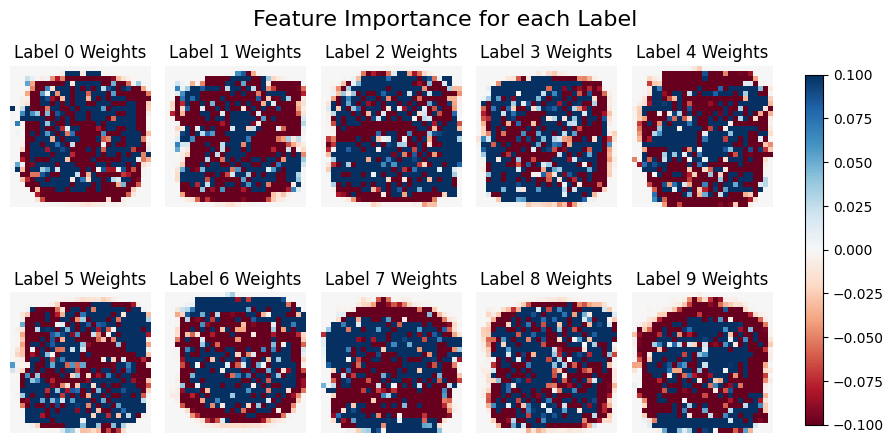

In [12]:
# Feature Importance Analysis
logistic_coefficients = lr.coef_
print(f"Coefficients shape: {logistic_coefficients.shape}\n")

fig, axes = plt.subplots(2, 5, figsize=(9, 5))
for i in range(10):
    row = i // 5
    col = i % 5

    # Reshape Coefficients to Image Shape
    weights_image = logistic_coefficients[i].reshape(28, 28)

    im = axes[row, col].imshow(weights_image, cmap='RdBu', vmin=-0.1, vmax=0.1)
    axes[row, col].set_title(f'Label {i} Weights')
    axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0, 0.88, 1])

cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
plt.colorbar(im, cax=cbar_ax)
plt.suptitle('Feature Importance for each Label', fontsize=16)
plt.show()

Confusion Matrix:



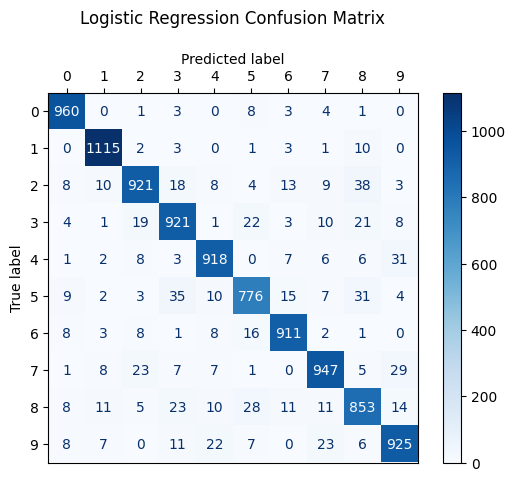


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.92      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000


The label with the highest accuracy (98.238%) is 1
The label with the lowest accuracy (86.996%) is 5


In [18]:
# Confusion Matrix
print("Confusion Matrix:\n")

logistic_cm = confusion_matrix(y_test, logistic_test_pred)
logistic_disp = ConfusionMatrixDisplay(confusion_matrix=logistic_cm)
logistic_disp.plot(cmap='Blues')

# Move x-axis (Predicted Labels) to the Top
ax = plt.gca()
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

plt.title("Logistic Regression Confusion Matrix\n")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, logistic_test_pred))

# Further Analysis
logistic_label_accuracy = logistic_cm.diagonal() / logistic_cm.sum(axis=1)
low_acc_label = np.argmin(logistic_label_accuracy)
high_acc_label = np.argmax(logistic_label_accuracy)

print(f"\nThe label with the highest accuracy ({logistic_label_accuracy[high_acc_label]*100:.3f}%) is {high_acc_label}")
print(f"The label with the lowest accuracy ({logistic_label_accuracy[low_acc_label]*100:.3f}%) is {low_acc_label}")

## Random Forest

### BuIld and Train

In [19]:
# Build Random Forest Model
rf = RandomForestClassifier(
    n_estimators=200,
    criterion='gini',
    random_state=42,
    n_jobs=-1
)

print(f"\nRandom Forest Classifier parameters:")
print(f"- Type: {type(rf).__name__}")
params = rf.get_params()
for param, value in params.items():
    print(f"- {param}: {value}")


Random Forest Classifier parameters:
- Type: RandomForestClassifier
- bootstrap: True
- ccp_alpha: 0.0
- class_weight: None
- criterion: gini
- max_depth: None
- max_features: sqrt
- max_leaf_nodes: None
- max_samples: None
- min_impurity_decrease: 0.0
- min_samples_leaf: 1
- min_samples_split: 2
- min_weight_fraction_leaf: 0.0
- monotonic_cst: None
- n_estimators: 200
- n_jobs: -1
- oob_score: False
- random_state: 42
- verbose: 0
- warm_start: False


In [20]:
# Train Model
start_time_rf = time.time()

rf.fit(X_train_split, y_train_split)
training_time_rf = time.time() - start_time_rf
print(f"Training time for Random Forest Classifier: {training_time_rf:.2f} seconds")

Training time for Random Forest Classifier: 49.48 seconds


### Evaluate

Validation Accuracy: 96.85%

Test Accuracy: 96.98%
Confusion Matrix:



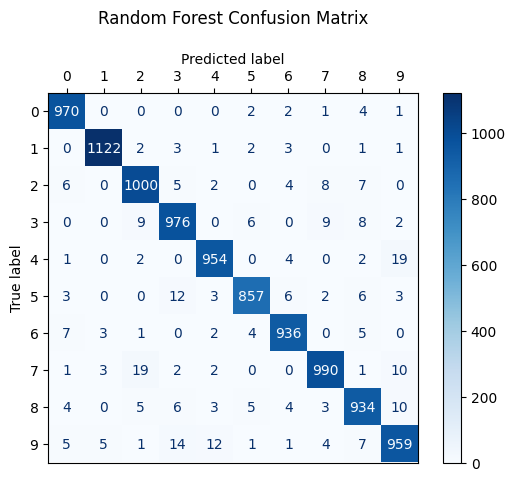


Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


The label with the highest accuracy (98.980%) is 0
The label with the lowest accuracy (95.045%) is 9


In [22]:
# Evaluate model on validation set
rf_val_pred = rf.predict(X_val)
rf_val_accuracy = accuracy_score(y_val, rf_val_pred)
print(f"Validation Accuracy: {rf_val_accuracy*100:.2f}%")

# Evaluate model on test set
pred = rf.predict(X_test_flat)
rf_test_accuracy = accuracy_score(y_test, pred)
print(f"\nTest Accuracy: {rf_test_accuracy*100:.2f}%")

# Confusion Matrix
print("Confusion Matrix:\n")
rf_cm = confusion_matrix(y_test, pred)
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm)
rf_disp.plot(cmap='Blues')

ax = plt.gca()
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

plt.title("Random Forest Confusion Matrix\n")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, pred))

# Further Analysis
rf_label_accuracy = rf_cm.diagonal() / rf_cm.sum(axis=1)
low_acc_label = np.argmin(rf_label_accuracy)
high_acc_label = np.argmax(rf_label_accuracy)

print(f"\nThe label with the highest accuracy ({rf_label_accuracy[high_acc_label]*100:.3f}%) is {high_acc_label}")
print(f"The label with the lowest accuracy ({rf_label_accuracy[low_acc_label]*100:.3f}%) is {low_acc_label}")

RF importance shape: (784,)



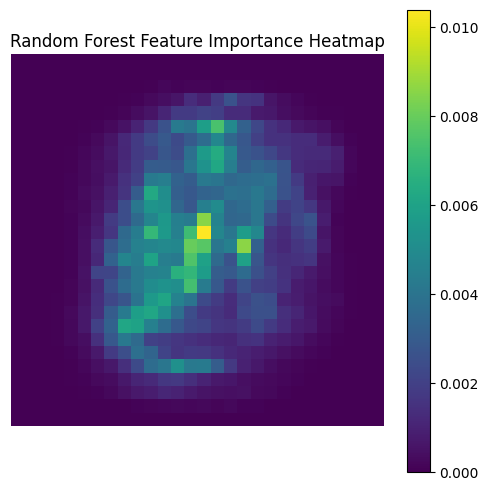

In [25]:
# Feature Importance Analysis
rf_importances = rf.feature_importances_
print(f"RF importance shape: {rf_importances.shape}\n")

# Reshape to 28×28
importance_image = rf_importances.reshape(28, 28)

plt.figure(figsize=(6, 6))
plt.imshow(importance_image, cmap='viridis')
plt.title("Random Forest Feature Importance Heatmap")
plt.axis('off')

plt.colorbar()
plt.show()

# Neural Network Models

## Multilayer Perceptron (MLP)

### Train

In [28]:
# Build Multilayer Perceptron Model

def create_mlp():
    # Build Model
    multilayer_perceptron = Sequential([

        Flatten(input_shape=(28, 28)),

        Dense(256, activation='elu'),    # Consider using other activation function if dying ReLu found
        Dropout(0.25),                   # Prevent overfitting

        Dense(128, activation='elu'),
        Dropout(0.25),

        Dense(64, activation='elu'),
        Dropout(0.25),

        Dense(32, activation='elu'),
        Dropout(0.25),

        Dense(10, activation='softmax')  # Softmax for 10 classes
    ])

    # Compile Model
    multilayer_perceptron.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return multilayer_perceptron

mlp = create_mlp()
mlp.summary()

# Train MLP

# Training tracking and optimizing tool
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# Different early_stopping to control validation loss
# early_stopping = keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )

start_time = time.time()

# Train Model
mlp_train = mlp.fit(
    X_train_nn_split, y_train_onehot_split,
    validation_data=(X_val_nn, y_val_onehot),
    epochs=15,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1
)

# Calculate training time
mlp_time = time.time() - start_time

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,522 (955.16 KB)

 Trainable params: 244,522 (955.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.7471 - loss: 0.7815 - val_accuracy: 0.9312 - val_loss: 0.2295
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9078 - loss: 0.3144 - val_accuracy: 0.9437 - val_loss: 0.1830
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9278 - loss: 0.2455 - val_accuracy: 0.9507 - val_loss: 0.1627
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9403 - loss: 0.2013 - val_accuracy: 0.9593 - val_loss: 0.1365
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9500 - loss: 0.1720 - val_accuracy: 0.9638 - val_loss: 0.1223
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9538 - loss: 0.1532 - val_accuracy: 0.9697 - val_loss: 0.1229
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9592 - loss: 0.1388 - val_accuracy: 0.9680 - val_loss: 0.1100
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9614 - loss: 0.1302 - val_accuracy:

### Evaluate

In [34]:
# Evaluate model
print(f"Training time: {mlp_time:.2f} seconds\n")

mlp_val_loss, mlp_val_accuracy = mlp.evaluate(X_val_nn, y_val_onehot, verbose=1)
print(f"\nNeural Network Validation Accuracy: {mlp_val_accuracy*100:.2f}%")
print(f"Neural Network Validation Loss: {mlp_val_loss*100:.2f}%\n")

mlp_test_loss, mlp_test_accuracy = mlp.evaluate(X_test_nn, y_test_onehot, verbose=1)
print(f"\nNeural Network Test Accuracy: {mlp_test_accuracy*100:.2f}%")
print(f"Neural Network Test Loss: {mlp_test_loss*100:.2f}%")

Training time: 61.23 seconds

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9756 - loss: 0.0942

Neural Network Validation Accuracy: 97.77%
Neural Network Validation Loss: 9.11%

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9743 - loss: 0.0855

Neural Network Test Accuracy: 97.85%
Neural Network Test Loss: 7.30%


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1. Classification Report:
              precision    recall  f1-score   support

     Digit 0       0.98      0.99      0.99       980
     Digit 1       0.99      0.99      0.99      1135
     Digit 2       0.98      0.98      0.98      1032
     Digit 3       0.96      0.99      0.97      1010
     Digit 4       0.98      0.98      0.98       982
     Digit 5       0.99      0.96      0.98       892
     Digit 6       0.98      0.99      0.98       958
     Digit 7       0.98      0.97      0.97      1028
     Digit 8       0.98      0.97      0.97       974
     Digit 9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Confusion Matrix:



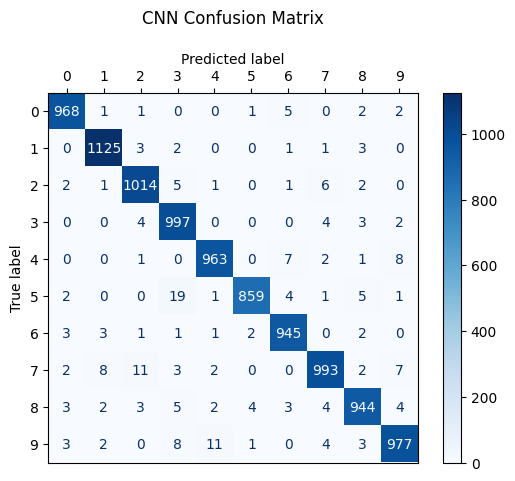


Error Analysis:



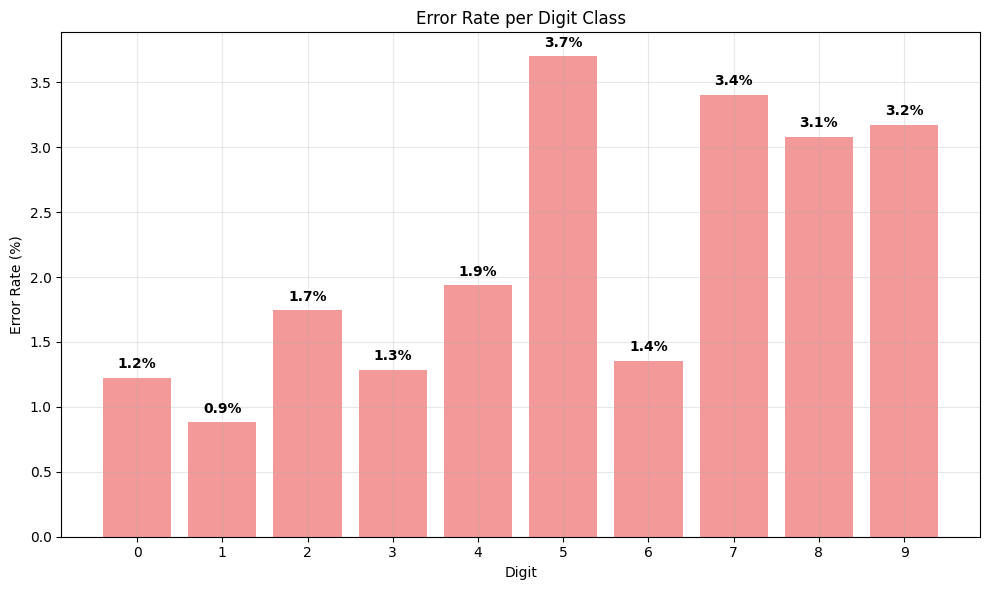

In [35]:
# Detain Evaluation of MLP

# Prediction
y_test_pred_mlp = mlp.predict(X_test_nn)
y_test_pred_mlp_classes = np.argmax(y_test_pred_mlp, axis=1)

# Classification Report
print("\n1. Classification Report:")
print(classification_report(y_test, y_test_pred_mlp_classes,
                          target_names=[f'Digit {i}' for i in range(10)]))

# Confusion Matrix
print("Confusion Matrix:\n")
cm = confusion_matrix(y_test, y_test_pred_mlp_classes)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_disp.plot(cmap='Blues')

ax = plt.gca()
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

plt.title("CNN Confusion Matrix\n")
plt.show()

# Error Analysis
print("\nError Analysis:\n")

errors = (y_test != y_test_pred_mlp_classes)
error_rate_per_digit = []

for digit in range(10):
    digit_mask = (y_test == digit)
    digit_errors = errors[digit_mask].sum()
    digit_total = digit_mask.sum()
    error_rate = digit_errors / digit_total * 100
    error_rate_per_digit.append(error_rate)

# Visualize error rates
plt.figure(figsize=(10, 6))
bars = plt.bar(range(10), error_rate_per_digit, color='lightcoral', alpha=0.8)
plt.xlabel('Digit')
plt.ylabel('Error Rate (%)')
plt.title('Error Rate per Digit Class')
plt.xticks(range(10))
plt.grid(True, alpha=0.3)

for i, rate in enumerate(error_rate_per_digit):
    plt.text(i, rate + 0.05, f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Convolutional Neural Network (CNN)

### Train

In [ ]:
# # Load the model
# cnn = load_model('mnist_cnn.keras')

In [ ]:
def build_cnn():
    # Build model
    convolutional_neural_network = keras.Sequential([

        Input(shape=(28, 28, 1)),
        Conv2D(32, (3, 3), strides=1, padding='same', activation='relu',),
        MaxPooling2D((2, 2)),
        # Conv2D(filters=64, kernel_size=3, strides=2, padding='same')    # Consider substitue MaxPooling2D with Strided Conv2D to reduce Loss

        # layers.Concatenate()([                                          # Another choice is Hybrid MaxPooling/ Or change the Pooling function
          #     MaxPooling2D(pool_size=(2, 2)),
          #     AveragePooling2D(pool_size=(2, 2))
        # ])

        Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(10, activation='softmax')
    ])

    # Compile model
    convolutional_neural_network.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return convolutional_neural_network

cnn = build_cnn()
cnn.summary()

# Train CNN

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

start_time = time.time()

# Train model
cnn_train = cnn.fit(
    X_train_nn_split, y_train_onehot_split,
    validation_data=(X_val_nn, y_val_onehot),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

cnn_time = time.time() - start_time

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,362 (868.60 KB)

 Trainable params: 222,362 (868.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.8174 - loss: 0.5688 - val_accuracy: 0.9775 - val_loss: 0.0819
Epoch 2/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.9798 - loss: 0.0640 - val_accuracy: 0.9802 - val_loss: 0.0676
Epoch 3/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 91s 79ms/step - accuracy: 0.9881 - loss: 0.0405 - val_accuracy: 0.9817 - val_loss: 0.0662
Epoch 4/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 75s 71ms/step - accuracy: 0.9907 - loss: 0.0287 - val_accuracy: 0.9830 - val_loss: 0.0574
Epoch 5/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 58s 69ms/step - accuracy: 0.9936 - loss: 0.0199 - val_accuracy: 0.9855 - val_loss: 0.0593
Epoch 6/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 59s 70ms/step - accuracy: 0.9940 - loss: 0.0177 - val_accuracy: 0.9880 - val_loss: 0.0423
Epoch 7/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 60s 71ms/step - accuracy: 0.9948 - loss: 0.0163 - val_accuracy: 0.9857 - val_loss: 0.0614
Epoch 8/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 80s 69ms/step - accuracy: 0.9967 - loss: 0.0112 - 

In [ ]:
# cnn.save('mnist_cnn.keras')

### Evaluate

In [ ]:
# Evaluation
print(f"Training time: {cnn_time:.2f} seconds\n")

cnn_val_loss, cnn_val_accuracy = cnn.evaluate(X_val_nn, y_val_onehot, verbose=1)
print(f"\nNeural Network Validation Accuracy: {cnn_val_accuracy*100:.2f}%")
print(f"Neural Network Validation Loss: {cnn_val_loss*100:.2f}%\n")

cnn_test_loss, cnn_test_accuracy = cnn.evaluate(X_test_nn, y_test_onehot, verbose=1)
print(f"\nNeural Network Test Accuracy: {cnn_test_accuracy*100:.2f}%")
print(f"Neural Network Test Loss: {cnn_test_loss*100:.2f}%")

Training time: 788.22 seconds

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9884 - loss: 0.0371

Neural Network Validation Accuracy: 98.80%
Neural Network Validation Loss: 4.23%

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9892 - loss: 0.0367

Neural Network Test Accuracy: 99.00%
Neural Network Test Loss: 3.29%


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step

1. Classification Report:
              precision    recall  f1-score   support

     Digit 0       0.99      0.99      0.99       980
     Digit 1       0.99      0.99      0.99      1135
     Digit 2       0.99      0.99      0.99      1032
     Digit 3       0.99      0.99      0.99      1010
     Digit 4       0.99      1.00      0.99       982
     Digit 5       0.99      0.99      0.99       892
     Digit 6       1.00      0.99      0.99       958
     Digit 7       1.00      0.98      0.99      1028
     Digit 8       0.99      0.99      0.99       974
     Digit 9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

2. Confusion Matrix:



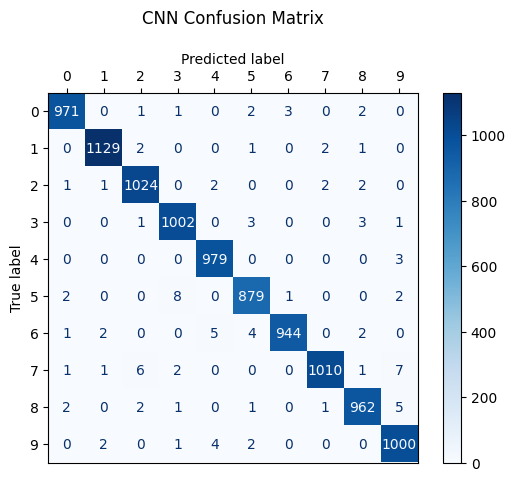


3. Error Analysis:



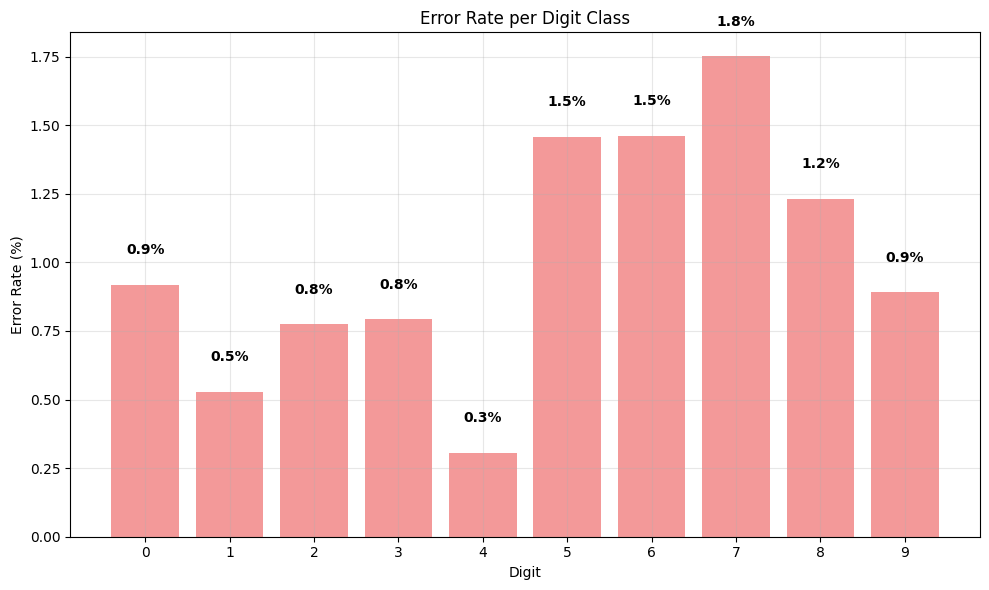

In [ ]:
# Detain Evaluation of CNN

# Prediction
y_test_pred_cnn = cnn.predict(X_test_nn)
y_test_pred_cnn_classes = np.argmax(y_test_pred_cnn, axis=1)

# Classification Report
print("\n1. Classification Report:")
print(classification_report(y_test, y_test_pred_cnn_classes,
                          target_names=[f'Digit {i}' for i in range(10)]))

# Confusion Matrix
print("Confusion Matrix:\n")
cm = confusion_matrix(y_test, y_test_pred_cnn_classes)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_disp.plot(cmap='Blues')

ax = plt.gca()
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

plt.title("CNN Confusion Matrix\n")
plt.show()

# Error Analysis
print("\nError Analysis:\n")

errors = (y_test != y_test_pred_cnn_classes)
error_rate_per_digit = []

for digit in range(10):
    digit_mask = (y_test == digit)
    digit_errors = errors[digit_mask].sum()
    digit_total = digit_mask.sum()
    error_rate = digit_errors / digit_total * 100
    error_rate_per_digit.append(error_rate)

# Visualize error rates
plt.figure(figsize=(10, 6))
bars = plt.bar(range(10), error_rate_per_digit, color='lightcoral', alpha=0.8)
plt.xlabel('Digit')
plt.ylabel('Error Rate (%)')
plt.title('Error Rate per Digit Class')
plt.xticks(range(10))
plt.grid(True, alpha=0.3)

for i, rate in enumerate(error_rate_per_digit):
    plt.text(i, rate + 0.05, f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary

Model Comparison:



/tmp/ipython-input-3986376613.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(models, rotation=45, ha='right')


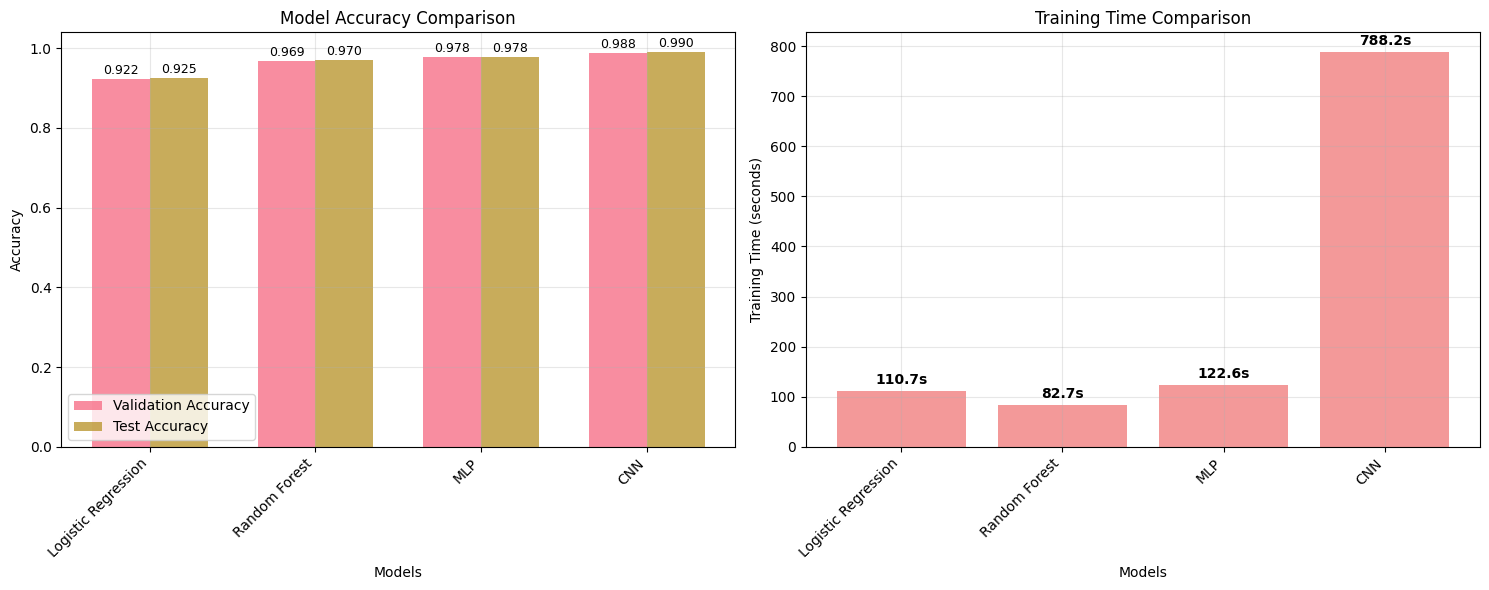

In [ ]:
## Result Summary
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'MLP', 'CNN'],
    'Validation Accuracy': [logistic_val_accuracy, rf_val_accuracy, mlp_val_accuracy, cnn_val_accuracy],
    'Test Accuracy': [logistic_test_accuracy, rf_test_accuracy, mlp_test_accuracy, cnn_test_accuracy],
    'Training Time (s)': [training_time, training_time_rf, mlp_time, cnn_time]
}

results_df = pd.DataFrame(results)

## Visualize
print("Model Comparison:\n")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
models = results_df['Model']
test_acc = results_df['Test Accuracy']
val_acc = results_df['Validation Accuracy']

x = np.arange(len(models))
width = 0.35

bars1 = axes[0].bar(x - width/2, val_acc, width, label='Validation Accuracy', alpha=0.8)
bars2 = axes[0].bar(x + width/2, test_acc, width, label='Test Accuracy', alpha=0.8)

axes[0].set_xlabel('Models')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for i, (val, test) in enumerate(zip(val_acc, test_acc)):
    axes[0].text(i - width/2, val + 0.005, f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, test + 0.005, f'{test:.3f}', ha='center', va='bottom', fontsize=9)

# Training time comparison
training_times = results_df['Training Time (s)']
bars = axes[1].bar(models, training_times, color='lightcoral', alpha=0.8)
axes[1].set_xlabel('Models')
axes[1].set_ylabel('Training Time (seconds)')
axes[1].set_title('Training Time Comparison (on CPU)')
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3)

for i, time_val in enumerate(training_times):
    axes[1].text(i, time_val + max(training_times)*0.01, f'{time_val:.1f}s',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Web Deployment with Gradio

In [ ]:
# Load the model
cnn = load_model('mnist_cnn.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Load and preprocess image
def load_preprocess(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize((28, 28))
    img_array = np.array(img)
    img_array = img_array / 255.0

    if img_array.mean() > 0.5:
        img_array = 1 - img_array

    img_array = img_array.reshape(1, 28, 28, 1)
    return img_array

In [ ]:
# Plot result
def create_prediction_plot(samples, predictions, true_labels=None, predicted_labels=None):
    num_samples = samples.shape[0]

    # Multiple sample
    if num_samples > 1:
        fig, axes = plt.subplots(1, min(num_samples, 5), figsize=(15, 3))
        if num_samples == 1:
            axes = [axes]

        for i in range(min(num_samples, 5)):
            prediction_probs = predictions[i]
            max_prob = np.max(prediction_probs)
            predicted_label = predicted_labels[i]

            if true_labels is not None:
                true_label = true_labels[i]
                title_color = 'green' if predicted_label == true_label else 'red'
                title = f"True: {true_label}, Pred: {predicted_label}\nConf: {max_prob:.2%}"
            else:
                title_color = 'green'
                title = f"Pred: {predicted_label}\nConf: {max_prob:.2%}"

            axes[i].imshow(samples[i].squeeze(), cmap='gray')
            axes[i].set_title(title, color=title_color)
            axes[i].axis('off')

        plt.tight_layout()

    # Single sample
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        prediction_probs = predictions[0]
        max_prob = np.max(prediction_probs)
        predicted_label = predicted_labels[0] if predicted_labels is not None else np.argmax(prediction_probs)

        # Image plot
        ax1.imshow(samples[0].squeeze(), cmap='gray')
        if true_labels is not None:
            true_label = true_labels[0]
            title_color = 'green' if predicted_label == true_label else 'red'
            ax1.set_title(f"True: {true_label}, Pred: {predicted_label}\nConf: {max_prob:.2%}",
                         color=title_color)
        else:
            ax1.set_title(f"Predicted: {predicted_label}\nConf: {max_prob:.2%}", color='green')
        ax1.axis('off')

        # Probability bar plot
        ax2.bar(range(10), prediction_probs, color='gray', alpha=0.7)
        ax2.bar(predicted_label, prediction_probs[predicted_label], color='red', alpha=0.7)
        ax2.set_xticks(range(10))
        ax2.set_title('Predicted Probabilities')
        ax2.set_xlabel('Digits')
        ax2.set_ylabel('Probability')

        plt.tight_layout()

    # Convert plot to image
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    plt.close(fig)

    return Image.open(buf)

In [ ]:
# Predict image
def predict_handler(image, label, num_samples, X_test_nn, y_test_onehot, cnn):

    # Case 1: Image upload
    if image is not None:
        img_array = load_preprocess(image)
        predictions = cnn.predict(img_array, verbose=0)
        predicted_label = np.argmax(predictions[0])

        result_image = create_prediction_plot(
            img_array,
            predictions,
            predicted_labels=[predicted_label]
        )

        return result_image

    # Case 2: Test set samples
    elif label is not None and num_samples is not None and num_samples > 0:

        # Specific digit
        if label != -1:
            target_indices = np.where(np.argmax(y_test_onehot, axis=1) == label)[0]
            if len(target_indices) < num_samples:
                print(f"Warning: Only {len(target_indices)} samples available for digit {label}.")
            indices = np.random.choice(target_indices, num_samples, replace=False)

        # Random
        else:
            indices = np.random.randint(0, X_test_nn.shape[0], num_samples)

        samples = X_test_nn[indices]
        true_labels = np.argmax(y_test_onehot[indices], axis=1)
        predictions = cnn.predict(samples.reshape(num_samples, 28, 28, 1), verbose=0)
        predicted_labels = np.argmax(predictions, axis=1)

        result_image = create_prediction_plot(
            samples,
            predictions,
            true_labels=true_labels,
            predicted_labels=predicted_labels
        )

        return result_image

    else:
        return None

In [ ]:
# Create Gradio interface
def create_gradio_interface(X_test_nn, y_test_onehot, cnn):

    with gr.Blocks(
        title="MNIST Classifier",
        css=".responsive-img img {width: 100% !important; height: auto !important;}"
    ) as demo:
        # Welcome popup guide
        with gr.Row(visible=True) as welcome_popup:
            with gr.Column():
                gr.Markdown("""
                ## Welcome to MNIST Digit Classifier!

                This tool lets you interact with a trained Convolutional Neural Network (CNN) that recognizes handwritten digits, particularly those from the MNIST dataset.

                ### How to use this tools:

                **Option 1: Upload Your Own Image**
                - Click on the "Upload Digit Image" area
                - Upload a handwritten digit (0-9) (You can either draw one using Paint or browse the Internet)
                - The image will be automatically preprocessed to grayscale
                - Click "Predict" to see the result

                **Option 2: Test on Dataset Samples (10,000 samples)**
                - Choose a specific digit (0-9) or just let the tool choose randomly
                - Adjust the number of samples (1-10)
                - Click "Predict" to see predictions on test set images

                ### Understanding the Results:
                - **Single sample**: Shows the image and probability distribution chart
                - **Multiple samples**: Shows a grid of images with predictions
                - **Green titles 🟢**: Correct predictions ✅
                - **Red titles 🔴**: Incorrect predictions ❌
                - **Confidence score**: Shows how certain the model is with the prediction

                ### Tips:
                - For best results with uploaded images, use clear handwritten digits on white background
                - Dark digits on light background work best
                - The tool can only work with single digit image

                ### About the Model:
                This model was trained on the MNIST dataset (70,000 handwritten digits).
                It learns spatial patterns (edges, curves, strokes) to classify digits from 0 to 9.

                ---
                *Click "Got it!" to start using the tool*
                """)

                close_btn = gr.Button("Got it!", variant="primary", size="lg")

        # Main content
        with gr.Row(visible=False) as main_content:
            with gr.Column():
                gr.Markdown("# MNIST Digit Classifier")
                gr.Markdown("Upload your own digit image or test on random samples from the test set")

        with gr.Row(visible=False) as controls_row:
            # Left column - Controls
            with gr.Column(scale=0.5):
                gr.Markdown("**Upload Digit Image**")

                # Image upload
                image_input = gr.Image(
                    type="filepath",
                    label="Upload Digit Image",
                    height=200
                )

                gr.Markdown("---")
                gr.Markdown("**OR test on dataset samples:**")

                # Label selection
                label_input = gr.Dropdown(
                    choices=[("Random", -1)] + [(str(i), i) for i in range(10)],
                    value=-1,
                    label="Select Digit Label",
                    interactive=True
                )

                # Number of samples
                num_samples_input = gr.Slider(
                    minimum=1,
                    maximum=10,
                    value=1,
                    step=1,
                    label="Number of Samples",
                    interactive=True
                )

                # Predict button
                predict_btn = gr.Button("Predict", variant="primary", size="lg")

                # Clear button
                clear_btn = gr.Button("Clear", variant="secondary")

            # Right column - Results
            with gr.Column(scale=1):
                gr.Markdown("### Prediction Results")
                output_image = gr.Image(
                    label="Results",
                    elem_classes=["responsive-img"],
                    height=550)

        # Event handlers
        close_btn.click(
            fn=lambda: (gr.update(visible=False), gr.update(visible=True), gr.update(visible=True)),
            inputs=None,
            outputs=[welcome_popup, main_content, controls_row]
        )

        predict_btn.click(
            fn=lambda img, lbl, num: predict_handler(img, lbl, num, X_test_nn, y_test_onehot, cnn),
            inputs=[image_input, label_input, num_samples_input],
            outputs=output_image
        )

        clear_btn.click(
            fn=lambda: (None, -1, 1, None),
            inputs=None,
            outputs=[image_input, label_input, num_samples_input, output_image]
        )

    return demo

In [ ]:
# Launch the interface
demo = create_gradio_interface(X_test_nn, y_test_onehot, cnn)
demo.launch(share=True, debug=True)

/usr/local/lib/python3.12/dist-packages/gradio/layouts/column.py:59: UserWarning: 'scale' value should be an integer. Using 0.5 will cause issues.
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://48dde19529c88ce3cd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://48dde19529c88ce3cd.gradio.live


# END